In [17]:
## Libraries

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from numpy.linalg import inv, solve
from scipy.stats import f

In [15]:
from IPython.display import display

'''In this problem set you will look at another potential source of risk / explanation of excess returns: Quality.
In order to proceed you need Microsoft Excel Problem_Set7_2023.xls in the folder. These files contain spreadsheets:
1) monthly returns of 49 value-weighted industry portfolios;
2) monthly returns of the Fama and French portfolios RMRF, SMB, HML, UMD, CMA, RMW, and rf;
3) monthly returns of a betting-against-beta factor BAB, quality minus junk factor QMJ
'''

def load_data():
    file_path = "../data/Problem_Set7.xlsx"
    sheet_names = ["Industry portfolios (VW)", "BAB,QMJ", "FF 5 factors+UMD"]
    industry_data = pd.read_excel(file_path, sheet_name=sheet_names[0], header=0)
    bab_qmj_data = pd.read_excel(file_path, sheet_name=sheet_names[1], header=0)
    ff_factors_data = pd.read_excel(file_path, sheet_name=sheet_names[2], header=0)
    return industry_data, bab_qmj_data, ff_factors_data

industry_data, bab_qmj_data, ff_factors_data = load_data()

def pre_process_data(industry_data, bab_qmj_data, ff_factors_data):
    industry_data['Date'] = pd.to_datetime(industry_data.iloc[:, 0], format='%Y%m')
    bab_qmj_data['Date'] = pd.to_datetime(bab_qmj_data.iloc[:, 0], format='%Y%m')
    ff_factors_data['Date'] = pd.to_datetime(ff_factors_data.iloc[:, 0], format='%Y%m')
    for df in [industry_data, bab_qmj_data, ff_factors_data]:
        df.drop(df.columns[0], axis=1, inplace=True)
        df.set_index('Date', inplace=True)
        # assigning nan to missing values
        df.replace(-99.99, np.nan, inplace=True)
    bab_qmj_data *= 100     
    return industry_data, bab_qmj_data, ff_factors_data

industry_data, bab_qmj_data, ff_factors_data = pre_process_data(industry_data, bab_qmj_data, ff_factors_data)

print("industry_data (first 20 rows):")
display(industry_data.head(20))

print("\nbab_qmj_data (first 20 rows):")
display(bab_qmj_data.head(20))

print("\nff_factors_data (first 20 rows):")
display(ff_factors_data.head(20))


industry_data (first 20 rows):


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,3.04,-0.46,2.57,-2.19,-2.54,-5.07,-0.70,-0.07,-0.15,-0.42,...,0.42,-2.53,0.04,-1.06,-4.21,-0.93,-1.74,-4.52,1.34,1.68
1963-08-01,-0.32,4.73,5.50,2.14,7.15,5.03,7.84,5.28,6.22,4.59,...,5.59,7.38,4.22,6.62,1.07,4.50,2.90,3.35,4.94,7.19
1963-09-01,-1.94,-1.53,-0.90,1.23,-4.23,-5.15,-2.26,2.98,-1.37,-3.97,...,-1.99,-3.86,-1.65,1.15,-2.51,-3.35,-1.36,-4.19,-3.91,1.04
1963-10-01,-0.13,2.69,1.10,-1.28,5.78,15.66,1.96,-1.99,4.25,2.70,...,3.41,1.78,1.41,0.41,1.11,-0.27,1.54,5.02,0.50,2.64
1963-11-01,-3.06,-0.39,-0.58,-0.72,-5.63,-0.83,-3.97,-0.62,-0.18,-1.44,...,-0.23,3.80,-4.03,-1.07,-3.61,-3.52,-4.19,-4.89,0.89,0.15
1963-12-01,3.25,2.45,5.80,1.21,5.98,-2.49,-1.46,-2.75,4.26,-0.50,...,-0.27,4.19,-0.66,0.35,1.75,1.88,1.51,1.14,1.43,5.83
1964-01-01,0.68,0.90,2.33,0.99,-1.69,-0.90,-1.04,5.99,1.74,-0.85,...,4.01,3.86,-2.24,2.85,-0.47,-1.89,0.53,-4.47,-0.39,1.38
1964-02-01,-0.99,1.57,0.88,-0.17,2.64,2.04,2.63,7.31,0.94,1.49,...,-0.33,7.01,1.94,1.55,7.08,3.79,3.03,-1.43,5.17,2.84
1964-03-01,-3.35,1.08,6.51,6.93,10.37,3.84,0.68,-1.57,2.32,0.98,...,-0.48,2.86,4.60,2.35,4.04,1.58,-0.97,0.45,0.58,-7.04



bab_qmj_data (first 20 rows):


,BAB,QMJ
Date,,
1963-07-01,0.812285,0.471979
1963-08-01,-1.215830,-0.625561
1963-09-01,1.068651,0.612808
1963-10-01,-1.875605,2.077934
1963-11-01,-0.519820,-0.880388
1963-12-01,0.012884,0.413060
1964-01-01,0.612817,0.588298
1964-02-01,-0.501539,-0.403447
1964-03-01,-0.188251,-0.972986



ff_factors_data (first 20 rows):


,Mkt-RF,SMB,HML,RMW,CMA,RF,UMD
Date,,,,,,,
1963-07-01,-0.39,-0.46,-0.82,0.72,-1.16,0.27,0.270105
1963-08-01,5.07,-0.81,1.63,0.42,-0.40,0.25,1.591270
1963-09-01,-1.57,-0.48,0.19,-0.80,0.23,0.27,-1.057191
1963-10-01,2.53,-1.29,-0.11,2.75,-2.26,0.29,2.801265
1963-11-01,-0.85,-0.84,1.66,-0.34,2.22,0.27,-1.807065
1963-12-01,1.83,-1.87,-0.11,0.18,-0.31,0.29,1.796375
1964-01-01,2.24,0.09,1.64,0.21,1.51,0.30,1.057534
1964-02-01,1.54,0.30,2.83,0.04,0.87,0.26,0.783778
1964-03-01,1.41,1.43,3.36,-2.01,2.94,0.31,0.615571


In [ ]:
'''a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
'''

# question a) 
''' To estimate the beta for each portfolio, we will run a time series regression of the portfolios returns against the market excess returns (RMRF).
For each portfolio, we will regress its excess returns (portfolio return - risk-free rate) on the market excess returns (Mkt-RF).
The reason why we regress excess returns is to isolate the systematic risk component that is captured by beta.'''

def estimate_betas(industry_data, ff_factors_data):
    market_excess_returns = ff_factors_data['Mkt-RF']
    risk_free = ff_factors_data['RF']
    betas = {}
    for column in industry_data.columns: 
        portfolio_excess_returns = industry_data[column] - risk_free
        portfolio_excess_returns.name = column
        market_excess_returns.name = 'Mkt-RF'

        df = pd.concat([portfolio_excess_returns, market_excess_returns], axis=1)
        
        model = sm.OLS(df[column], sm.add_constant(df['Mkt-RF']), missing='drop').fit()
        betas[column] = model.params['Mkt-RF']
    return betas

betas = estimate_betas(industry_data, ff_factors_data)
print("\nEstimated Betas for each portfolio:")
for portfolio, beta in betas.items():
    print(f"{portfolio}: {beta:.4f}")


Estimated Betas for each portfolio:
Agric: 0.8845
Food : 0.6857
Soda : 0.8306
Beer : 0.7562
Smoke: 0.6652
Toys : 1.1745
Fun  : 1.3658
Books: 1.0784
Hshld: 0.8177
Clths: 1.1075
Hlth : 1.1229
MedEq: 0.9077
Drugs: 0.8120
Chems: 1.0510
Rubbr: 1.0857
Txtls: 1.1353
BldMt: 1.1744
Cnstr: 1.3088
Steel: 1.3011
FabPr: 1.1140
Mach : 1.2269
ElcEq: 1.2156
Autos: 1.1411
Aero : 1.1388
Ships: 1.1076
Guns : 0.8379
Gold : 0.6036
Mines: 1.1215
Coal : 1.1575
Oil  : 0.7969
Util : 0.5237
Telcm: 0.7809
PerSv: 1.1357
BusSv: 1.1732
Hardw: 1.2151
Softw: 1.6358
Chips: 1.4029
LabEq: 1.3239
Paper: 0.9817
Boxes: 0.9666
Trans: 1.0696
Whlsl: 1.0737
Rtail: 0.9977
Meals: 1.0632
Banks: 1.0663
Insur: 0.9631
RlEst: 1.2221
Fin  : 1.2452
Other: 1.1874


In [26]:
'''a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
'''

# question b)
def calculate_expected_returns(industry_data):
    expected_returns = industry_data.mean()
    return expected_returns
expected_returns = calculate_expected_returns(industry_data)
print("\nExpected Returns for each portfolio:")
print(expected_returns)


Expected Returns for each portfolio:
Agric    1.024028
Food     1.065340
Soda     1.163997
Beer     1.141497
Smoke    1.414151
Toys     0.847978
Fun      1.361065
Books    0.938688
Hshld    0.904059
Clths    1.085355
Hlth     1.032240
MedEq    1.153488
Drugs    1.096821
Chems    0.956157
Rubbr    1.099861
Txtls    1.070093
BldMt    1.022176
Cnstr    0.982269
Steel    0.736420
FabPr    0.714877
Mach     0.993812
ElcEq    1.160170
Autos    0.837870
Aero     1.191389
Ships    1.081389
Guns     1.198611
Gold     0.981682
Mines    1.095710
Coal     1.069352
Oil      0.985355
Util     0.836296
Telcm    0.869259
PerSv    0.706096
BusSv    1.001667
Hardw    0.972299
Softw    0.971090
Chips    1.050355
LabEq    1.094892
Paper    0.990123
Boxes    1.023148
Trans    0.970448
Whlsl    1.034367
Rtail    1.046404
Meals    1.194198
Banks    0.944074
Insur    1.028966
RlEst    0.689522
Fin      1.122747
Other    0.641883
dtype: float64


a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
"""

# question d)

No the shape is not consistent with the CAPM theory which predicts a linear relationship between expected return and beta. In other words, high beta portfolios should have higher expected returns. 
However, the plotted data is similar to what empirical data has shown, where low beta portfolios tend to have higher returns than predicted by CAPM, and high beta portfolios tend to have lower returns than predicted. This phenomenon is often referred to as the "low beta anomaly" or "betting against beta". '''

/Users/comecosmolabautiere/Desktop/Yale/Fall Semester/Fall 1/Quant Investing/Assignment/Quantitative-Investing/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 120573 (\N{MATHEMATICAL ITALIC SMALL BETA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


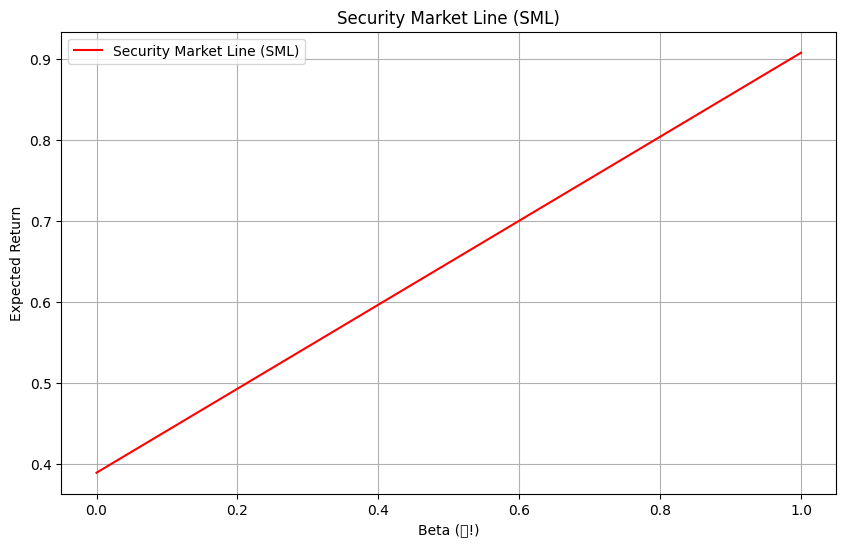

In [32]:
""" a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
"""

# question e)
''' The two points we know on the Security Market Line (SML) are the risk free asset (β = 0, expected return = Rf) and the market portfolio (β = 1, expected return = Rm).'''
def plot_security_market_line(ff_factors_data):
    Rf = ff_factors_data['RF'].mean()
    Rm = ff_factors_data['Mkt-RF'].mean() + Rf

    beta_values = [0, 1]
    expected_returns_sml = [Rf, Rm]

    plt.figure(figsize=(10, 6))
    plt.plot(beta_values, expected_returns_sml, color='red', label='Security Market Line (SML)')
    plt.xlabel('Beta (𝛽!)')
    plt.ylabel('Expected Return')
    plt.title('Security Market Line (SML)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_security_market_line(ff_factors_data)

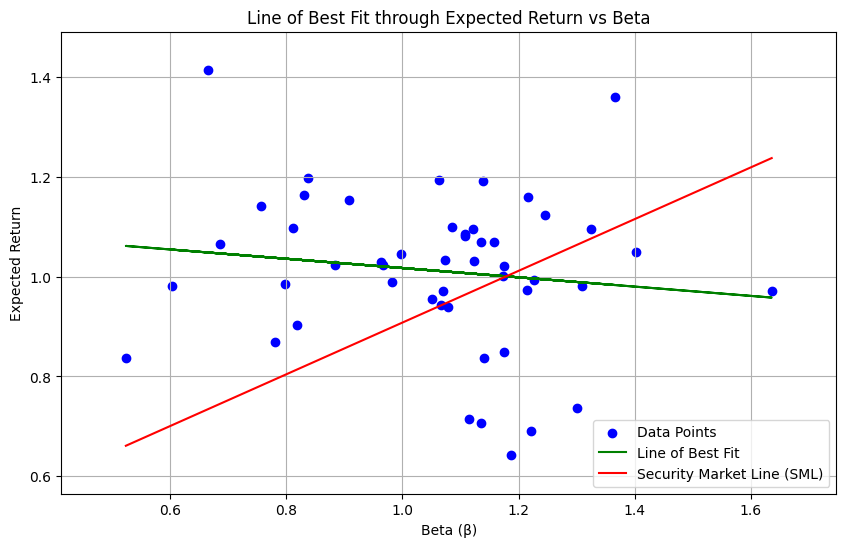

In [ ]:
""" a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
"""

# question f) 
def plot_line_of_best_fit(expected_returns, betas, ff_factors_data):
    beta_values = np.array(list(betas.values()))
    expected_return_values = np.array(list(expected_returns))

    # --- Plotting Setup ---
    plt.figure(figsize=(10, 6))

    # 1. Scatter plot of the data
    plt.scatter(beta_values, expected_return_values, color='blue', label='Data Points')

    # 2. Line of best fit for the data
    slope, intercept, r_value, p_value, std_err = stats.linregress(beta_values, expected_return_values)
    plt.plot(beta_values, intercept + slope * beta_values, color='green', label='Line of Best Fit')
    
    # 3. Security Market Line (SML)
    risk_free_rate = ff_factors_data['RF'].mean()
    market_risk_premium = ff_factors_data['Mkt-RF'].mean()
    
    # Extend the SML to the range of the data
    sml_x = np.array([beta_values.min(), beta_values.max()])
    sml_y = risk_free_rate + sml_x * market_risk_premium
    plt.plot(sml_x, sml_y, color='red', label='Security Market Line (SML)')
    
    # --- Formatting ---
    # Center the plot around the data with some padding
    x_margin = (beta_values.max() - beta_values.min()) * 0.1
    y_margin = (expected_return_values.max() - expected_return_values.min()) * 0.1
    plt.xlim(beta_values.min() - x_margin, beta_values.max() + x_margin)
    plt.ylim(expected_return_values.min() - y_margin, expected_return_values.max() + y_margin)
    
    plt.xlabel('Beta (β)')
    plt.ylabel('Expected Return')
    plt.title('Line of Best Fit through Expected Return vs Beta')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_line_of_best_fit(expected_returns, betas, ff_factors_data)

""" We can see that the line of best fit through the data deviates from the theoretical Security Market Line (SML). 
The empirical line of best fit appears to be flatter than the SML, indicating that low beta portfolios have higher returns than predicted by CAPM, while high beta portfolios have lower returns than predicted.
This might be caused by behavioral biases or market frictions. This implies that models should not solely rely on beta as a risk measure but consider other factors as well."""

""" a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
"""

# question g)
""" The main real life constraints is that access to leverage is limited for investors compared to what the CAPM assumes. 
So to reach higher expected returns, investors tend to buy high beta assets at a higher cost, which then drives down their returns."""


In [ ]:
""" a) Using the market proxy and the risk-free rate, estimate the 𝛽! for each of the portfolios.
b) Calculate the expected return of each of the portfolios for the time period specified (that is, estimate the expected return).
c) Plot the data on an axis of expected return vs 𝛽!.
d) Is this the shape you would expect to see for this data, given theory (like the CAPM) is true?
e) Plot the security market line you would expect to see in theory (note: A line can be specified by two points, think of the two points on the SML that you know).
f) Plot a line of best fit through the data you plotted in c). How does this line compare with the theoretical line in e)? What might cause this, and what kind of implications does this have for asset pricing models?
g) What kind of real life constraints might lead to this effect?
h) How would you take advantage of the findings in the graph if you thought the CAPM was the right model?
"""

# Question h) 
""" If I believed the CAPM was the correct model, then I would go long the portfolios that lie above the SML (since they are providing a positive risk-adjusted abnormal return, α>0) 
and short the portfolios that lie below the SML (since they are providing a negative risk-adjusted abnormal return, α<0)
"""
